### CPS Age Cohorts Example

In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.title_fontsize'] = 12
mpl.rcParams['legend.fontsize'] = 11
mpl.rc('font', family='URW Bookman')

os.chdir('/home/brian/Documents/CPS/data/clean/')

In [2]:
col = ['YEAR', 'MONTH', 'AGE', 'FEMALE', 'BASICWGT', 'LFS']
cols = ['year', 'month', 'age', 'female', 'basicwgt', 'emp']

yob = lambda x: x.YEAR - x.AGE

emp = lambda x: np.where(x.LFS == 'Employed', 1, 0)
emprt = lambda x: np.average(x.EMP, weights=x.BASICWGT)
query = '16 <= AGE <= 72 and FEMALE == @i'

d = {}
for name, i in [('Men', 0), ('Women', 1)]:
    data0 = (pd.concat([pd.read_stata(f'../EPI/epi_cpsmay_{year}.dta', 
                                      convert_categoricals=False, columns=cols)
                        for year in range(1973, 1976)])
               .rename({c: c.upper() for c in cols}, axis=1)
               .query(query)
               .assign(YOB = yob))
    data1 = (pd.concat([pd.read_stata(f'../EPI/epi_cpsbasic_{year}.dta', 
                                      convert_categoricals=False, columns=cols)
                        for year in range(1976, 1989)])
               .rename({c: c.upper() for c in cols}, axis=1)
               .query(query)
               .assign(YOB = yob))
    data2 = (pd.concat([pd.read_feather(f'cps{year}.ft', columns=col) 
                        for year in range (1989, 2026)])
               .query(query, engine='python')
               .assign(YOB = yob, EMP = emp))

    data = pd.concat([data0, data1, data2])

    data['Generation'] = pd.cut(data.YOB, 
                         [1900, 1927, 1945, 1964, 1980, 1996, 2012],
                         labels=['Greatest', 'Silent', 'Boomers', 
                                 'Gen X', 'Millennials', 'Zoomers'])
    groups = ['Generation', 'AGE']

    d[name] = (data.groupby(groups, observed=False)
                   .apply(emprt, include_groups=False).unstack().T * 100)

In [56]:
ls = {'Greatest': {'lw': 1.2, 'color': '#662c91', 'ls': '-', 'marker': 'o', 'ms': 2}, 
      'Silent': {'lw': 1.0, 'color': '#63a088', 'ls': '-', 'marker': '', 'ms': 2}, 
      'Boomers': {'lw': 2.0, 'color': '#56638a', 'ls': '--', 'marker': '', 'ms': 2}, 
      'Gen X': {'lw': 1.2, 'color': '#56203d', 'ls': ':', 'marker': '', 'ms': 2}, 
      'Millennials': {'lw': 1.0, 'color': '#483a58', 'ls': '-', 'marker': '', 'ms': 2}, 
      'Zoomers': {'lw': 2.5, 'color': '#53dd6c', 'ls': '-', 'marker': '', 'ms': 2}}

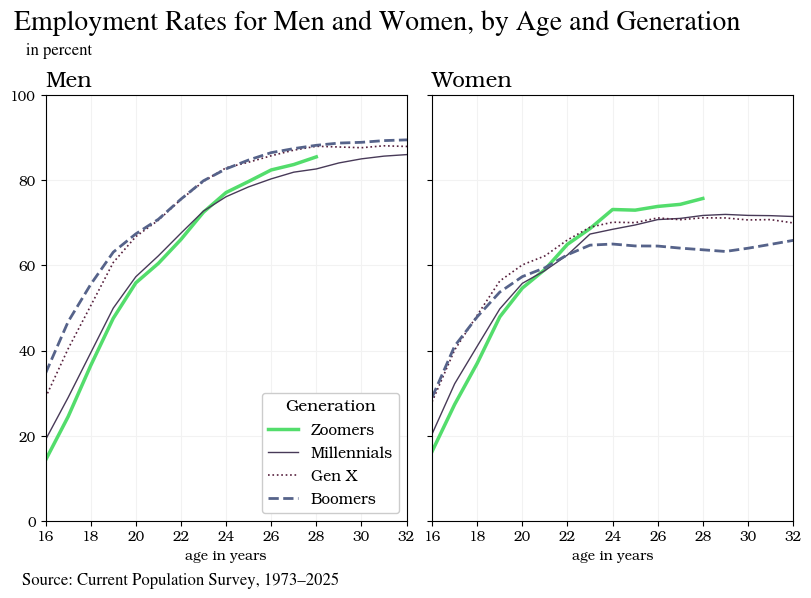

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.0, 5.0), sharey=True, 
                               sharex=True, constrained_layout=True)

def cohort_plot(ax, dataframe, style_dict):
    for column in ['Zoomers', 'Millennials', 'Gen X', 'Boomers']:
        s = style_dict[column]
        ax.plot(dataframe.index, dataframe[column], 
                label=column,
                color=s['color'], 
                linestyle=s['ls'], 
                linewidth=s['lw'], 
                marker=s['marker'], 
                markersize=s['ms'])

for ax, cat in [(ax1, 'Men'), (ax2, 'Women')]:
    cohort_plot(ax, d[cat], ls)
    ax.set_ylim(0,100)
    ax.set_xlim(16,32)
    ax.set_title(cat, loc='left', fontsize=16)
    ax.set_xlabel('age in years')
    ax.grid('on', color='#F2F2F2')

# Formatting
fig.text(0.01, 1.075, 'Employment Rates for Men and Women, by Age and Generation', 
         size=20, fontname='Nimbus Roman')
fig.text(0.025, 1.025, 'in percent', 
         size=12, fontname='Nimbus Roman')
fig.text(0.02, -0.035, "Source: Current Population Survey, 1973–2025", 
         size=12, fontname='Nimbus Roman');
ax1.legend(title='Generation')

plt.show()

In [52]:
d

{'Men': Generation   Greatest     Silent    Boomers      Gen X  Millennials    Zoomers
 AGE                                                                           
 16                NaN        NaN  34.706100  29.024506    19.106312  14.314999
 17                NaN        NaN  46.802972  40.450242    29.005561  24.515365
 18                NaN        NaN  55.551629  50.538208    39.489737  36.505809
 19                NaN        NaN  63.117658  60.691701    49.981217  47.600234
 20                NaN        NaN  67.408794  66.768695    57.350330  55.909496
 21                NaN        NaN  70.836660  70.610307    62.256320  60.483275
 22                NaN        NaN  75.561155  75.478900    67.573077  66.093091
 23                NaN        NaN  79.873832  79.712210    72.759489  72.504799
 24                NaN        NaN  82.662291  82.912038    76.123720  77.105708
 25                NaN        NaN  84.742534  84.226927    78.439596  79.702134
 26                NaN        NaN

In [ ]:

# for 

# #fig.set_figheight(6.5)
# #fig.set_figwidth(9.0)
# for ax, cat, legend in [(ax1, 'Men', False), (ax2, 'Women', True)]:
#     d[cat].plot(ax=ax, legend=legend, lw=lw)
#     ax.text(14, 96, cat, size=18, weight='bold', fontname='Nimbus Roman')
#     for y_val in [20, 30, 40, 50, 60, 70, 80, 90]:
#         ax.hlines(y=y_val, xmin=16, xmax=67, 
#                   linewidth=0.5, color='gray', zorder=0)
#         if ax == ax1:
#             ax.text(15.5, y_val-0.5, f'{y_val}%', ha='right')
#     for age_val in [18, 25, 35, 45, 55, 64]: 
#         ax.vlines(x=age_val, ymin=15, ymax=95, 
#                   linewidth=0.5, color='gray', zorder=0)
#         ax.text(age_val, 13, f'{age_val}', ha='center')
#     ax.axis('off')
# fig.text(0, 1.01, 'Employment Rate by Age and Generation', 
#          size=22, fontname='Nimbus Roman')
# fig.text(0, -0.02, "Source: Current Population Survey, 1973–2025", 
#          size=12, fontname='Nimbus Roman');